# MLG-HW2 
The competition of **link prediction** task in class

## connect to google drive

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## GPU Information
if have any gpus

In [29]:
!nvidia-smi

Sun Apr 23 14:39:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   2421MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Package dependencies

In [30]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch_geometric.nn import Node2Vec
import networkx as nx 
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import trange

### use the ggplot style

In [32]:
plt.style.use('ggplot')

## Data Explories
* There are 4324 edges
* There are 2707 vertices in the graph
* Most of the features are zeros, since all bars in bar ploting are smaller than .5

In [33]:
train_df = pd.read_csv('/content/gdrive/MyDrive/hw2_data/dataset3/train.csv')
print(train_df.describe())
print(train_df.head())
print()
print(f"There are {train_df[train_df['label']==1]['id'].count()} edges in training graph.")
print(f"There are {train_df['to'].unique().max()} vertices in the training graph.")

                to         from        label
count  2572.000000  2572.000000  2572.000000
mean    439.468896   447.962286     0.494946
std     245.571595   251.356563     0.500072
min       1.000000     0.000000     0.000000
25%     235.000000   227.000000     0.000000
50%     445.000000   453.500000     0.000000
75%     657.250000   674.000000     1.000000
max     875.000000   875.000000     1.000000
      id   to  from  label
0  E2143  612    59      1
1  E1615  843   189      1
2  E2103  677   416      1
3  E3131  797   506      0
4  E1257  175   856      0

There are 1273 edges in training graph.
There are 875 vertices in the training graph.


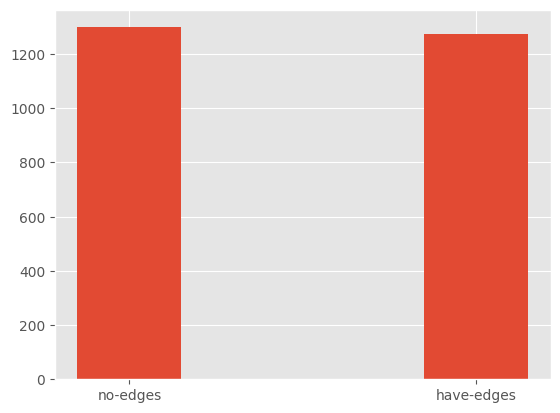

In [34]:
plt.bar(
    x=[0,1],
    height=( train_df[train_df['label']==0]['id'].count(), train_df[train_df['label']==1]['id'].count() ),
    width=.3, tick_label=('no-edges', 'have-edges')
)
plt.show()

In [35]:
with open("/content/gdrive/MyDrive/hw2_data/dataset3/content.csv", 'r') as f:
    lines = f.readlines()
    attributes = [ [] for _ in range(len(lines)) ]
    for line in lines:
        line = line.split()
        line = list( map(int, line) )
        attributes[line[0]].extend(line[1:])

attributes = np.array(attributes)
print(f"There are {attributes.shape[0]} nodes")
print(f"There are {attributes.shape[1]} attributes per node")

There are 877 nodes
There are 1703 attributes per node


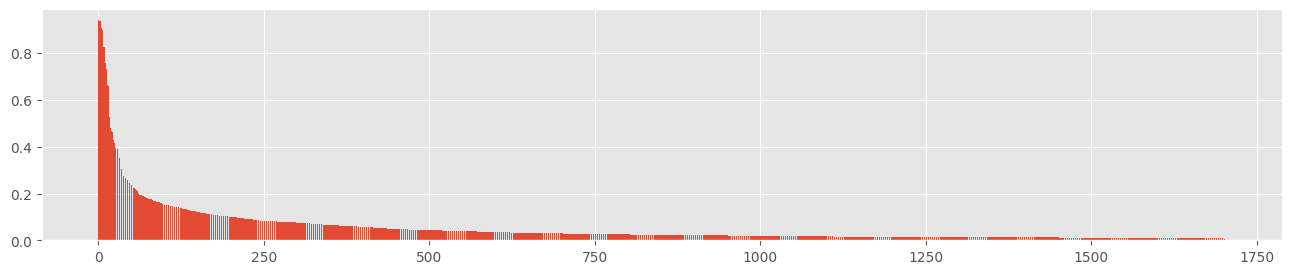

In [36]:
plt.figure(figsize=(16, 3))
plt.bar(range(attributes.shape[1]), sorted(np.mean(attributes, axis=0), reverse=True))
plt.show()

## Split data based on transductive rule
> https://zqfang.github.io/2021-08-12-graph-linkpredict/

> https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html

In [37]:
class KFold:

    def __init__(self, graph, edges, no_edges, k=5):
        self.k = k
        # since positive and negative samples are not in same size
        self.fold_size_pos = len(edges) // k
        self.fold_size_neg = len(no_edges) // k
        # create the full graph without removing any edges
        self.origin_graph = graph

        # shuffle the positive and negative edges
        random.shuffle(edges)
        random.shuffle(no_edges)
        self.pos_edges = edges
        self.neg_edges = no_edges


    def get_fold(self, fold):
        if fold >= self.k:
            print("Out of the boundary!!")
        else:
            subgraph = self.origin_graph.copy()
            subgraph.remove_edges_from(
                self.pos_edges[fold*self.fold_size_pos: (fold+1)*self.fold_size_pos]
            )
            pos_samples = self.pos_edges[fold*self.fold_size_pos: (fold+1)*self.fold_size_pos]
            neg_samples = self.neg_edges[fold*self.fold_size_neg: (fold+1)*self.fold_size_neg]

            return subgraph, pos_samples, neg_samples
            
    def get_k(self):
        return self.k

In [38]:
def construct_attr_graph(edges, attributes):
    graph = nx.Graph()
    graph.add_edges_from(edges)
    start = len(graph.edges)
    attributes = np.argwhere(attributes==1)
    for node, attr_node in attributes:
        graph.add_edge(node, attr_node+start)
    return graph

In [39]:
def edge2index(edges): # convert networkx edges to pyg edge_indices
    edge_idx = [[], []]
    for v1, v2 in edges:
        edge_idx[0].append(v1)
        edge_idx[1].append(v2)
        edge_idx[0].append(v2)
        edge_idx[1].append(v1)
    return edge_idx

def train_embed(edges, **param): # this edges is for pyg
    model = Node2Vec(
        torch.tensor(edges, dtype=torch.long), embedding_dim=param['embed_dim'], p=param['p'], q=param['q'], 
        walk_length=param['walk_len'], context_size=param['context_size'], walks_per_node=param['walks']   
    )
    device = param['device']
    loader = model.loader(batch_size=param['batch_size'], shuffle=True, num_workers=2)
    optimizer = torch.optim.Adam(list(model.parameters()), lr=0.1)
    model.to(device)
    for epoch in range(20):
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            total_loss += loss
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} loss ===> {total_loss:.6f}")
    return model

def L1_dist(u, v):
    return np.abs(u-v)
def L2_dist(u, v):
    return np.square(u-v)
def mul(u, v):
    return u*v
def avg(u, v):
    return (u+v)/2

def feature_extraction(samples, n2v):
    embed_dict = n2v.cpu().state_dict()['embedding.weight'].numpy()
    X = np.empty((0, embed_dict.shape[1]))
    for v1, v2 in samples:
        node_feature = mul(embed_dict[v1], embed_dict[v2])
        X = np.vstack( (X, node_feature) )
    return X

## Ensemble Learning algorithm
* Bagging Logistic Regression
* Boosting Logistic Regression

In [40]:
class BaggingClassifier:
    
    def __init__(self, n_samples):
        self.n_samples = n_samples
        self.clfs = [
            LogisticRegression() for _ in range(n_samples)
        ]

    def fit(self, X, y, sample_proba=.7):
        N = len(y)
        for clf in self.clfs:
            idx = np.random.choice(np.arange(N), int(N*sample_proba), replace=True)
            feat = X[idx]
            label = y[idx]
            clf.fit(feat, label)

    def predict_proba(self, X):
        result = np.zeros((len(X), 2))
        for clf in self.clfs:
            result += clf.predict_proba(X);
        return result / self.n_samples

In [41]:
def cross_validation(kfold, **param):

    ACC = []
    AP = []
    
    for fold in trange(kfold.get_k()):
        print()
        # validation on different folds
        graph, pos_samples, neg_samples = kfold.get_fold(fold)
        # use the subgraph (with removal) to train node2vec
        print("Training the embedding...")
        n2v = train_embed(edge2index(graph.edges), **param)

        # split pos_samples and neg_samples to training classifier and validating (3:1)
        train_pos_samples, valid_pos_samples = train_test_split(pos_samples, test_size=.25)
        train_neg_samples, valid_neg_samples = train_test_split(neg_samples, test_size=.25)

        train_samples = train_pos_samples + train_neg_samples
        train_labels = np.array(
            [1 for _ in range(len(train_pos_samples))] + [0 for _ in range(len(train_neg_samples))]
        )
        valid_samples = valid_pos_samples + valid_neg_samples
        valid_labels = np.array(
            [1 for _ in range(len(valid_pos_samples))] + [0 for _ in range(len(valid_neg_samples))]
        )
        # create the classifier (ex: logistic regression)
        clf = LogisticRegression()
        # train classifier
        train_X = feature_extraction(train_samples, n2v)
        print("Training classfier...")
        clf.fit(train_X, train_labels)

        # validation
        print("Start validation...")
        valid_X = feature_extraction(valid_samples, n2v)
        outputs = clf.predict_proba(valid_X)
        ap = average_precision_score(valid_labels, outputs[:, 1])
        acc = roc_auc_score(valid_labels, outputs[:, 1])
        print(f"Average Precision: {ap:.2f}")
        print(f"ROC_AUC Score:     {acc:.2f}")
        AP.append( ap )
        ACC.append( acc )

    return ACC, AP


## Running here
* setting parameters of node2vec
* run the cross validation
* finally, run all settings again on the whole graph; that is the origin graph for testing

In [42]:
param = {
    'p': 1, 'q': 1, 'embed_dim': 256, 'walks': 10,
    'context_size': 10, 'walk_len': 40, 'batch_size': 128, 
    'device': 'cuda:0' if torch.cuda.is_available() else 'cpu'
}

In [43]:
edges = ( train_df[train_df['label']==1][['to', 'from']].apply(tuple, axis=1) ).tolist()
no_edges = ( train_df[train_df['label']==0][['to', 'from']].apply(tuple, axis=1) ).tolist()
graph = construct_attr_graph(edges, attributes)
kfold_embed = KFold(graph, edges, no_edges, k=5)

### Runningn K-fold

In [44]:
acc_result, ap_result = cross_validation(kfold_embed, **param)

  0%|          | 0/5 [00:00<?, ?it/s]


Training the embedding...
Epoch 0 loss ===> 143.857513
Epoch 1 loss ===> 31.662422
Epoch 2 loss ===> 26.109579
Epoch 3 loss ===> 25.631451
Epoch 4 loss ===> 25.543055
Epoch 5 loss ===> 25.540483
Epoch 6 loss ===> 25.552347
Epoch 7 loss ===> 25.548918
Epoch 8 loss ===> 25.551048
Epoch 9 loss ===> 25.573065
Epoch 10 loss ===> 25.592962
Epoch 11 loss ===> 25.631714
Epoch 12 loss ===> 25.636208
Epoch 13 loss ===> 25.647932
Epoch 14 loss ===> 25.689400
Epoch 15 loss ===> 25.706757
Epoch 16 loss ===> 25.720743
Epoch 17 loss ===> 25.724674
Epoch 18 loss ===> 25.754221
Epoch 19 loss ===> 25.748619
Training classfier...
Start validation...
Average Precision: 0.69
ROC_AUC Score:     0.76

Training the embedding...
Epoch 0 loss ===> 145.523056
Epoch 1 loss ===> 31.862297
Epoch 2 loss ===> 26.120649
Epoch 3 loss ===> 25.627731
Epoch 4 loss ===> 25.556915
Epoch 5 loss ===> 25.558849
Epoch 6 loss ===> 25.535000
Epoch 7 loss ===> 25.590586
Epoch 8 loss ===> 25.594429
Epoch 9 loss ===> 25.614378
Epoc

In [27]:
print(acc_result)
print(ap_result)
best_fold = np.argmax(acc_result)

[0.7880561077358121, 0.8048548310328416, 0.7789288014110927, 0.7503989696783044, 0.7473751994848392]
[0.7814660563347497, 0.8217842316133537, 0.776491777590084, 0.7767530051257692, 0.7599460033402575]


### Finally 
training the node2vec model

In [ ]:
graph, pos_samples, neg_samples = kfold_embed.get_fold(best_fold)
print("Training the embedding...")
n2v = train_embed(edge2index(graph.edges), **param)
train_samples = pos_samples + neg_samples

Training the embedding...
Epoch 0 loss ===> 203.985886
Epoch 1 loss ===> 48.286148
Epoch 2 loss ===> 46.332901
Epoch 3 loss ===> 46.475529
Epoch 4 loss ===> 46.592655
Epoch 5 loss ===> 46.651760
Epoch 6 loss ===> 46.740894
Epoch 7 loss ===> 46.852264
Epoch 8 loss ===> 47.026352
Epoch 9 loss ===> 47.116360
Epoch 10 loss ===> 47.236557
Epoch 11 loss ===> 47.346878
Epoch 12 loss ===> 47.507629
Epoch 13 loss ===> 47.601158
Epoch 14 loss ===> 47.778843
Epoch 15 loss ===> 47.806477
Epoch 16 loss ===> 47.928375
Epoch 17 loss ===> 48.009857
Epoch 18 loss ===> 48.127682
Epoch 19 loss ===> 48.189510


Learning the classifier

In [ ]:
# create the classifier (ex: logistic regression)
# clf = LogisticRegression()
clf = LogisticRegression()

# train classifier
train_X = feature_extraction(train_samples, n2v)
train_y = np.array(
    [1 for _ in range(len(pos_samples))] + [0 for _ in range(len(neg_samples))]
)
print("Training classfier...")
clf.fit(train_X, train_y)

Training classfier...


testing on the final graph

In [ ]:
# load test data
test_df = pd.read_csv("/content/gdrive/MyDrive/hw2_data/dataset3/test.csv")
# testing
print("Start testing...")
valid_samples = ( test_df[['to', 'from']].apply(tuple, axis=1) ).tolist()
valid_X = feature_extraction(valid_samples, n2v)
outputs = clf.predict_proba(valid_X)
test_df.drop(columns=['to', 'from'])
test_df['prob'] = pd.Series(outputs[:, 1])
# store the csv
test_df.to_csv('/content/gdrive/MyDrive/hw2_data/dataset3/upload.csv', index=False)
print("finish testing")

Start testing...
finish testing
